# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 15.0 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=117f64d97433e37637b5684cbcff4db95383d1befbf431ffe63ab349f5fad1b6
  Stored in directory: /root/.cache/pip/wheels/29/16/24/752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=43c37bf6e583a6d9dff211c9812b6f21d72a9da8ef247cd8b5a44e40f70a0de2
  Stored in directory: /root/.cache/pip/w

# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset 

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

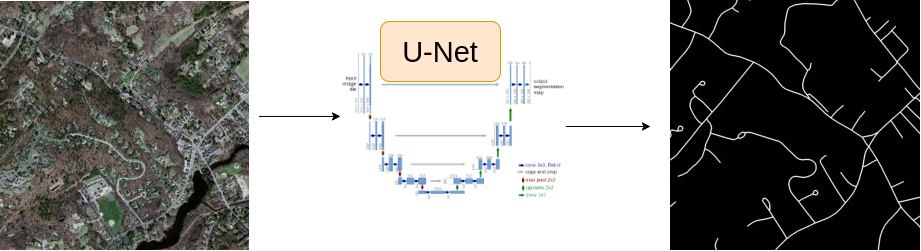

# Download Subset Dataset

In [2]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411
Receiving objects: 100% (411/411), 851.74 MiB | 30.10 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (401/401), done.


# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [4]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
CSV_FILE = '/content/Road_seg_dataset/train.csv'
DATA_DIR = '/content/Road_seg_dataset/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
BATCH_SIZE = 8
IMG_SIZE = 512

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [6]:
df = pd.read_csv(CSV_FILE)
df

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png
...,...,...
194,images/18178735_15.png,masks/18178735_15.png
195,images/24178480_15.png,masks/24178480_15.png
196,images/24629305_15.png,masks/24629305_15.png
197,images/23728495_15.png,masks/23728495_15.png


In [7]:
idx = 8
row = df.iloc[idx]

image_path = DATA_DIR + row['images']
mask_path = DATA_DIR + row['masks']


image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE) / 255.0

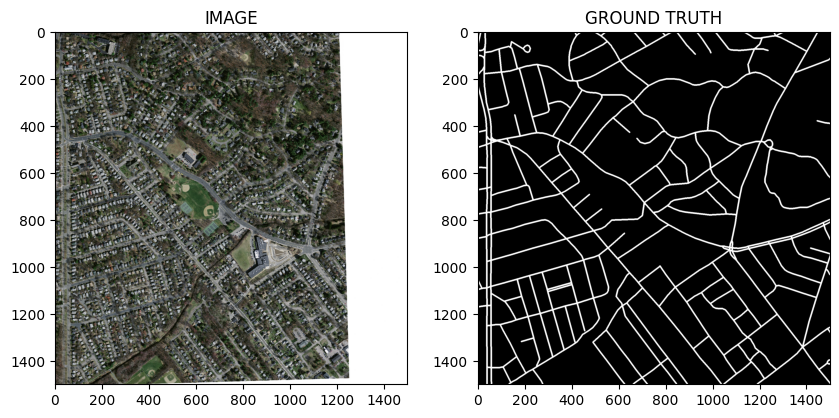

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

In [10]:
len(train_df), len(valid_df)

(159, 40)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [11]:
import albumentations as A

In [12]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE,IMG_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])
# no need for flip since it is validation set
def get_valid_augs():
  return A.Compose([A.Resize(IMG_SIZE,IMG_SIZE)])

# Task 4 : Create Custom Dataset 

In [13]:
from torch.utils.data import Dataset

In [14]:
class SegmentationDataset(Dataset):

  def __init__(self,df,augmentations):

    self.df = df
    self.augmentations = augmentations

  def __getitem__(self,x):

    row = df.iloc[x]

    image = DATA_DIR + row.images
    mask = DATA_DIR + row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # (h, w, c)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # (h, w)
    mask = np.expand_dims(mask,axis=-1) # (h, w, c)

    if self.augmentations:
        data = self.augmentations(image=image, mask=mask)
        image = data['image'] # (h, w, c)
        mask = data['mask']
    # (c,h,w)
    image = np.transpose(image,(2,0,1)).astype(np.float32)
    mask = np.transpose(mask,(2,0,1)).astype(np.float32)

    image = torch.Tensor(image)/255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

  def __len__(self):
    return len(self.df)

In [15]:
trainset = SegmentationDataset(train_df,get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [16]:
len(trainset),len(validset)

(159, 40)

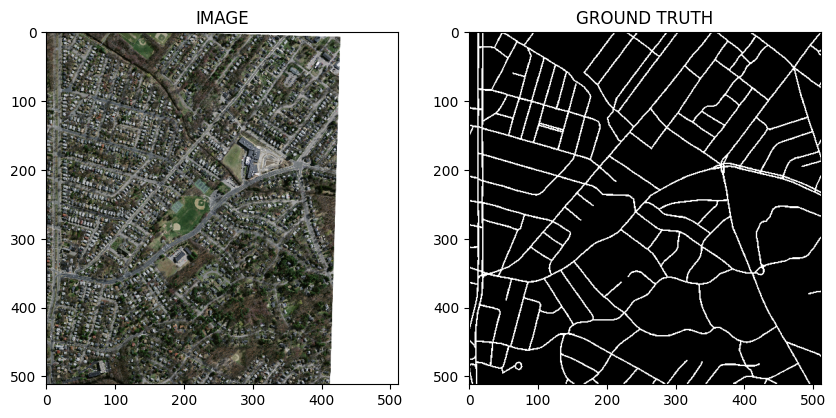

In [17]:
idx = 8

image, mask = trainset[idx]

helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [18]:
from torch.utils.data import DataLoader

In [19]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [20]:
print(f'total no. of batches in trainloader : {len(trainloader)}')
print(f'total no. of batches in validloader : {len(validloader)}')

total no. of batches in trainloader : 20
total no. of batches in validloader : 5


In [21]:
for image,mask in trainloader:
  print(f'One batch image shape : {image.shape}')
  print(f'One batch mask shape : {mask.shape}')
  break
  

One batch image shape : torch.Size([8, 3, 512, 512])
One batch mask shape : torch.Size([8, 1, 512, 512])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [22]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [31]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel,self).__init__()

    self.backbone = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )
  def forward(self,images, masks=None):
    logits = self.backbone(images)
    if masks != None:
      return logits, DiceLoss(mode='binary')(logits,masks) + nn.BCEWithLogitsLoss()(logits, masks)
    return logits

In [32]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (backbone): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
      

# Task 7 : Create Train and Validation Function 

In [33]:
def train_fn(data_loader, model,optimizer):
  model.train()
  total_loss = 0.0

  for images,masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits,loss = model(images,masks)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  return total_loss / len(data_loader)

In [38]:
def eval_fn(data_loader: DataLoader, model: SegmentationModel):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()
  
    return total_loss / len(data_loader)

# Task 8 : Train Model

In [35]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [40]:
best_valid_loss = np.Inf
for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt') # .pt = pytorch
    print('SAVED-MODEL')
    best_valid_loss = valid_loss

  print('Epoch: %d -- train_loss: %f -- valid_loss: %f'%(i+1, train_loss, valid_loss))

100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


SAVED-MODEL
Epoch: 1 -- train_loss: 0.426799 -- valid_loss: 0.366301


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


SAVED-MODEL
Epoch: 2 -- train_loss: 0.306081 -- valid_loss: 0.365939


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


SAVED-MODEL
Epoch: 3 -- train_loss: 0.279904 -- valid_loss: 0.244549


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


SAVED-MODEL
Epoch: 4 -- train_loss: 0.224376 -- valid_loss: 0.221428


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


SAVED-MODEL
Epoch: 5 -- train_loss: 0.184602 -- valid_loss: 0.155211


100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


SAVED-MODEL
Epoch: 6 -- train_loss: 0.144368 -- valid_loss: 0.129058


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


SAVED-MODEL
Epoch: 7 -- train_loss: 0.130747 -- valid_loss: 0.128925


100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


SAVED-MODEL
Epoch: 8 -- train_loss: 0.124902 -- valid_loss: 0.102500


100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


SAVED-MODEL
Epoch: 9 -- train_loss: 0.096226 -- valid_loss: 0.075265


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


SAVED-MODEL
Epoch: 10 -- train_loss: 0.092172 -- valid_loss: 0.074502


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


SAVED-MODEL
Epoch: 11 -- train_loss: 0.072367 -- valid_loss: 0.064881


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


SAVED-MODEL
Epoch: 12 -- train_loss: 0.068560 -- valid_loss: 0.053089


100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch: 13 -- train_loss: 0.058629 -- valid_loss: 0.072969


100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Epoch: 14 -- train_loss: 0.054589 -- valid_loss: 0.059787


100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


SAVED-MODEL
Epoch: 15 -- train_loss: 0.045674 -- valid_loss: 0.047599


100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


SAVED-MODEL
Epoch: 16 -- train_loss: 0.038598 -- valid_loss: 0.035365


100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Epoch: 17 -- train_loss: 0.042462 -- valid_loss: 0.041110


100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


SAVED-MODEL
Epoch: 18 -- train_loss: 0.039765 -- valid_loss: 0.028823


100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch: 19 -- train_loss: 0.035943 -- valid_loss: 0.028974


100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch: 20 -- train_loss: 0.042763 -- valid_loss: 0.029275


100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch: 21 -- train_loss: 0.037184 -- valid_loss: 0.036886


100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Epoch: 22 -- train_loss: 0.041126 -- valid_loss: 0.039969


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Epoch: 23 -- train_loss: 0.035950 -- valid_loss: 0.040146


100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


SAVED-MODEL
Epoch: 24 -- train_loss: 0.024840 -- valid_loss: 0.015646


100%|██████████| 5/5 [00:03<00:00,  1.26it/s]

SAVED-MODEL
Epoch: 25 -- train_loss: 0.014942 -- valid_loss: 0.010773


# Task 9 : Inference

In [44]:
idx = 8
model.load_state_dict(torch.load('/content/best_model.pt'))
image,mask = validset[idx]
logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pre_mask = (pred_mask > 0.5)*1.0

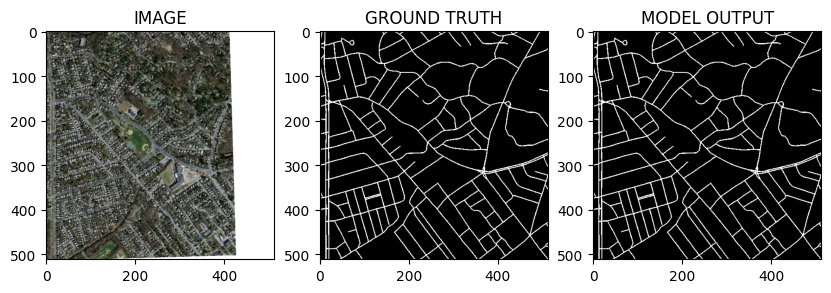

In [45]:
helper.show_image(image, mask, pre_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya

